In [38]:
import pathlib
import pickle

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc
import scipy.ndimage as scn
import scipy.interpolate as sci
import scipy.optimize as sco

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci
import blackjax

from pyia import GaiaData

from astroquery.gaia import Gaia
Gaia.login(credentials_file='/mnt/home/apricewhelan/.gaia/archive.login')

INFO:astroquery:Login to gaia TAP server


INFO: Login to gaia TAP server [astroquery.gaia.core]


INFO:astroquery:Login to gaia data server


OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [39]:
data_path = pathlib.Path('../data').resolve().absolute()
cache_path = pathlib.Path('../cache').resolve().absolute()

In [40]:
with open(cache_path / 'joint-model.pkl', 'rb') as f:
    JointModel, res_pars = pickle.load(f)

In [41]:
run_data = at.Table.read(cache_path / 'run_data.fits')
run_data = {k: np.array(run_data[k]) for k in run_data.colnames}

In [68]:
with open(data_path / 'galcen_frame.pkl', 'rb') as f:
    galcen_frame = pickle.load(f)

In [42]:
g = GaiaData(
    at.join(
        at.Table.read(data_path / 'gd1-GaiaDR3-PS1DR2-joined.fits'),
        at.Table.read(cache_path / 'optimized-member-prob.fits'), 
        keys='source_id'
    )
)

mask = (
    ((g.g0 - g.i0) < 1.) &
    (g.member_prob > 0.01)
)
g = g[mask]
c = g.get_skycoord(distance=False)

len(c)

3872

In [43]:
all_joined = {}
rv_priority = ['gaia', 'hecto', 'apogee', 'segue', 'sdss', 'lamost']

# Survey data

## Gaia

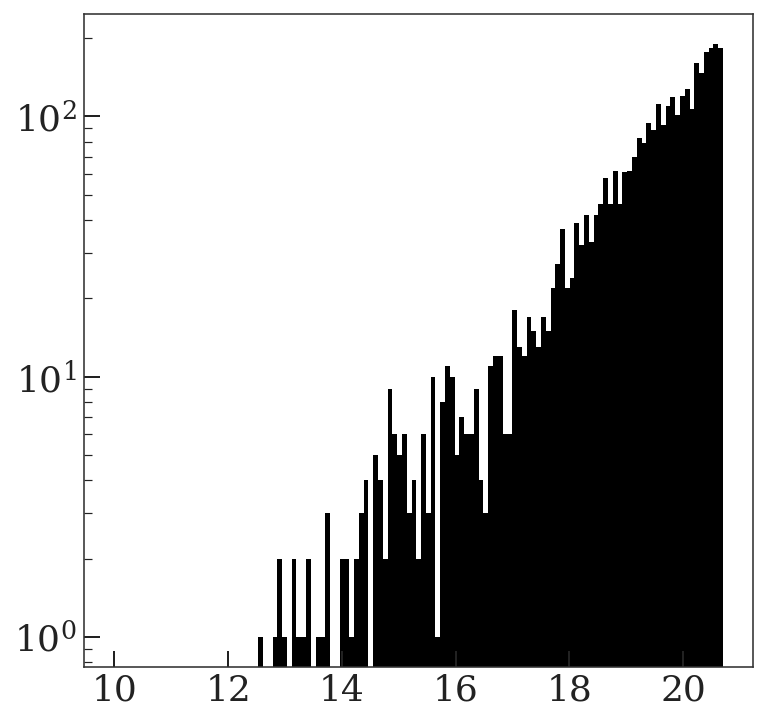

In [45]:
plt.hist(g.phot_g_mean_mag.value, bins=np.linspace(10, 20.7, 128));
plt.yscale('log')

In [46]:
t = g.data['source_id', 'member_prob'][(g.phot_g_mean_mag.value < 18)]
len(t)

439

In [47]:
job = Gaia.launch_job(
    query=("select * from gaiadr3.gaia_source as gaia "
           "JOIN tap_upload.table_test as tt ON tt.source_id = gaia.source_id"),
    upload_resource=t, 
    upload_table_name="table_test", 
    verbose=True
)
gaia_results = job.get_results()

Launched query: 'select  TOP 2000 * from gaiadr3.gaia_source as gaia JOIN tap_upload.table_test as tt ON tt.source_id = gaia.source_id'
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/sync
Content-type = multipart/form-data; boundary====1665430065823===
200 200
[('Date', 'Mon, 10 Oct 2022 19:27:46 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Content-Encoding', 'gzip'), ('Content-Disposition', 'attachment;filename="1665430066204O-result.vot"'), ('Transfer-Encoding', 'chunked'), ('Content-Type', 'application/x-votable+xml')]
Retrieving sync. results...
Query finished.


In [48]:
gaia_joined = at.join(
    g.data[['gd1_phi1', 'gd1_phi2', 'source_id']], 
    gaia_results,
    keys='source_id'
)
gaia_joined = gaia_joined[np.isfinite(gaia_joined['radial_velocity'])]
gaia_joined['gd1_rv'] = gaia_joined['radial_velocity']
gaia_joined['gd1_rv_err'] = gaia_joined['radial_velocity_error']
all_joined['gaia'] = gaia_joined

(-450.0, 400.0)

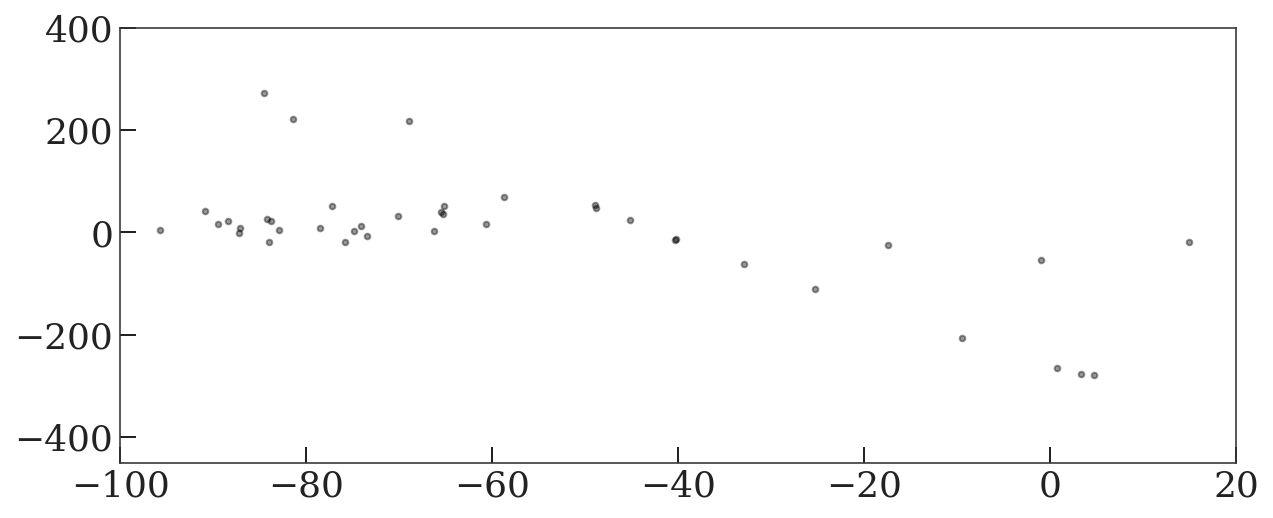

In [49]:
plt.figure(figsize=(10, 4))
plt.scatter(gaia_joined['gd1_phi1'], gaia_joined['radial_velocity'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

(-500.0, 400.0)

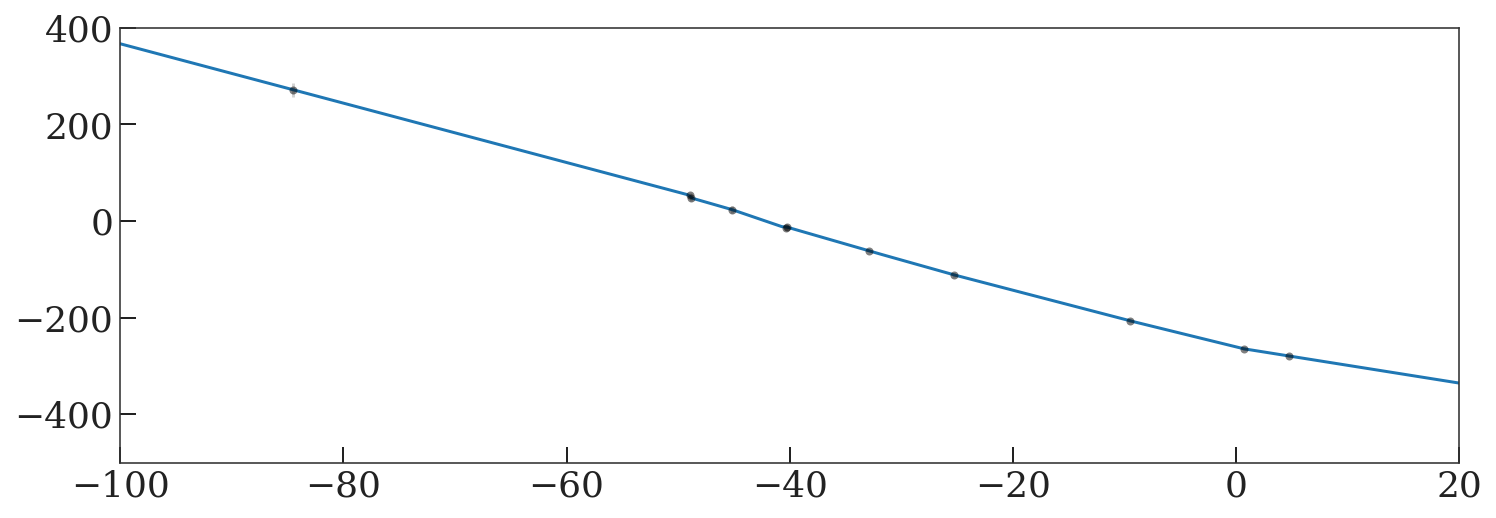

In [50]:
_strict = (
    (gaia_joined['member_prob'] > 0.9) &
    ((gaia_joined['gd1_phi1'] > -55) | 
     (gaia_joined['gd1_phi1'] <= -55) & (gaia_joined['gd1_rv'] > 80))
)

x = gaia_joined['gd1_phi1'][_strict]
y = gaia_joined['gd1_rv'][_strict]
yerr = gaia_joined['gd1_rv_err'][_strict]
fiducial_spl = sci.InterpolatedUnivariateSpline(
    x[np.argsort(x)],
    y[np.argsort(x)],
    k=1,
    w=1/yerr[np.argsort(x)]**2
)
with open(cache_path / 'fiducial_rv_spline.pkl', 'wb') as f:
    pickle.dump(fiducial_spl, f)

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(
    gaia_joined['gd1_phi1'][_strict],
    gaia_joined['gd1_rv'][_strict],
    gaia_joined['gd1_rv_err'][_strict],
    ls='none',
    marker='o',
    ecolor='#aaaaaa',
    alpha=0.5,
    ms=4
)

_grid = np.linspace(-100, 20, 256)
ax.plot(_grid, fiducial_spl(_grid), marker='')
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 400)

## APOGEE

In [51]:
allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allStarLite-dr17-synspec_rev1.fits')
allstar_c = coord.SkyCoord(
    allstar['RA'][np.isfinite(allstar['RA'])], 
    allstar['DEC'][np.isfinite(allstar['RA'])], 
    unit=u.deg
)

In [52]:
ap_idx, ap_sep, _ = c.match_to_catalog_sky(allstar_c)
sep_mask = (ap_sep < 2*u.arcsec)
apogee_joined = at.hstack((g.data[sep_mask], allstar[ap_idx[sep_mask]]))
apogee_joined = apogee_joined[np.isfinite(apogee_joined['VHELIO_AVG'])]
apogee_joined['gd1_rv'] = apogee_joined['VHELIO_AVG']
apogee_joined['gd1_rv_err'] = apogee_joined['VERR']
all_joined['apogee'] = apogee_joined

(-450.0, 400.0)

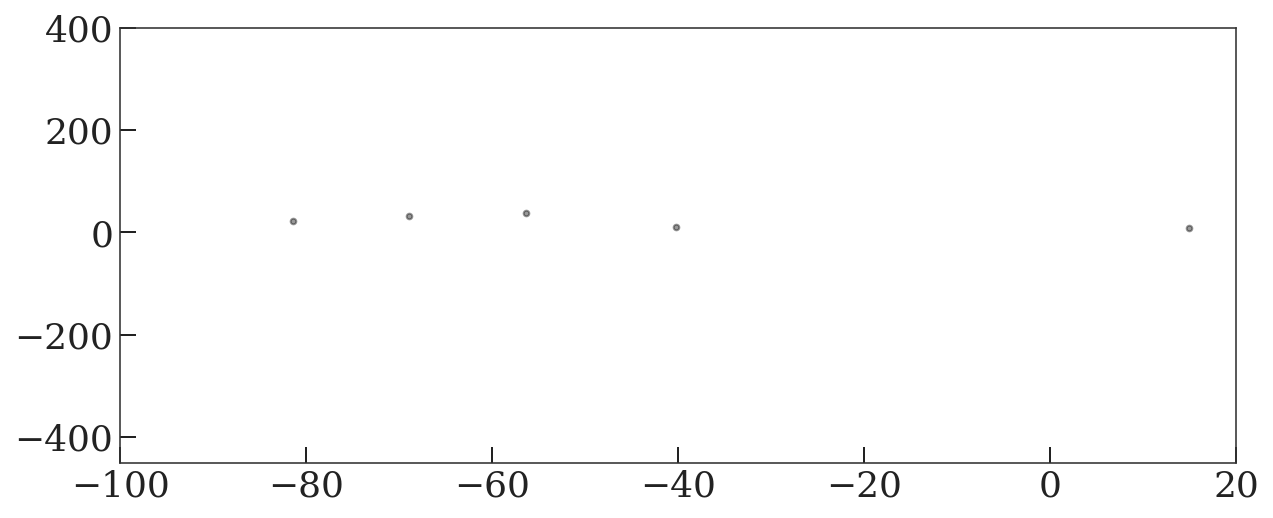

In [53]:
plt.figure(figsize=(10, 4))
plt.scatter(apogee_joined['gd1_phi1'], apogee_joined['VHELIO_AVG'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## SDSS/BOSS

In [54]:
sdss = at.Table.read('/mnt/home/apricewhelan/data/sdss/specObjAll-STAR.fits')
sdss['rv'] = speed_of_light.to(u.km/u.s) * sdss['z']
sdss['rv_err'] = speed_of_light.to(u.km/u.s) * sdss['zErr']

In [55]:
sdss_c = coord.SkyCoord(sdss['ra']*u.deg, sdss['dec']*u.deg)

In [56]:
sdss_idx, sdss_sep, _ = c.match_to_catalog_sky(sdss_c)
sep_mask = (sdss_sep < 2*u.arcsec)
sdss_joined = at.hstack((g.data[sep_mask], sdss[sdss_idx[sep_mask]]))
sdss_joined = sdss_joined[np.isfinite(sdss_joined['rv'])]
sdss_joined['gd1_rv'] = sdss_joined['rv']
sdss_joined['gd1_rv_err'] = sdss_joined['rv_err']
all_joined['sdss'] = sdss_joined

(-450.0, 400.0)

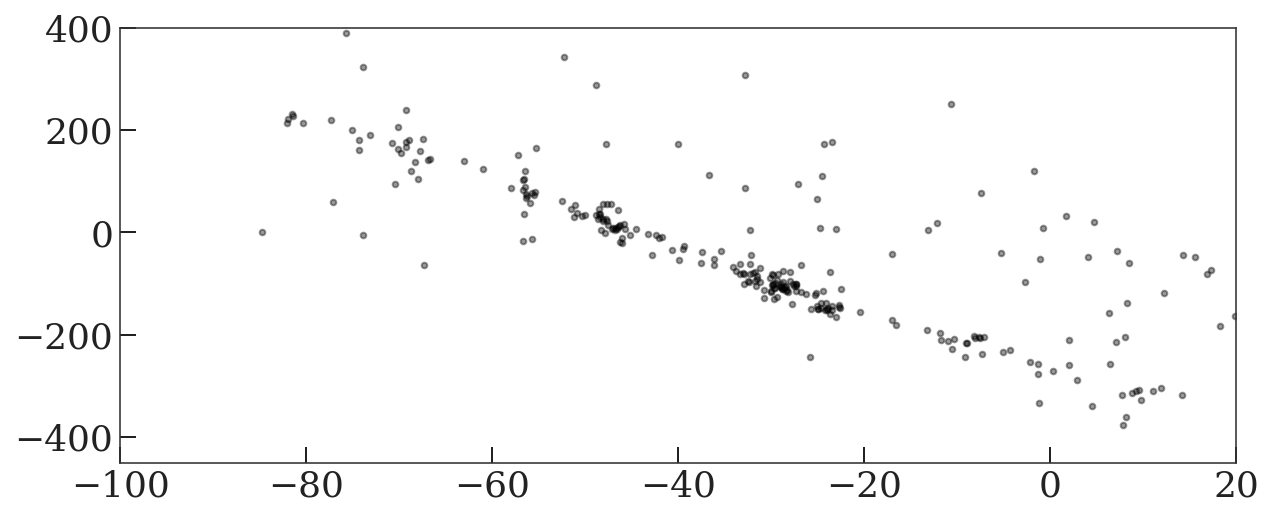

In [57]:
plt.figure(figsize=(10, 4))
plt.scatter(sdss_joined['gd1_phi1'], sdss_joined['rv'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## SEGUE

In [58]:
segue = at.Table.read('/mnt/home/apricewhelan/data/SEGUE/SEGUE-EDR3-xmatch-full.fits')

In [59]:
segue_joined = at.join(segue, g.data, keys='source_id')
segue_joined = segue_joined[np.isfinite(segue_joined['RV_ADOP'])]
segue_joined['gd1_rv'] = segue_joined['RV_ADOP']
segue_joined['gd1_rv_err'] = 5.  # ??
all_joined['segue'] = segue_joined

(-450.0, 400.0)

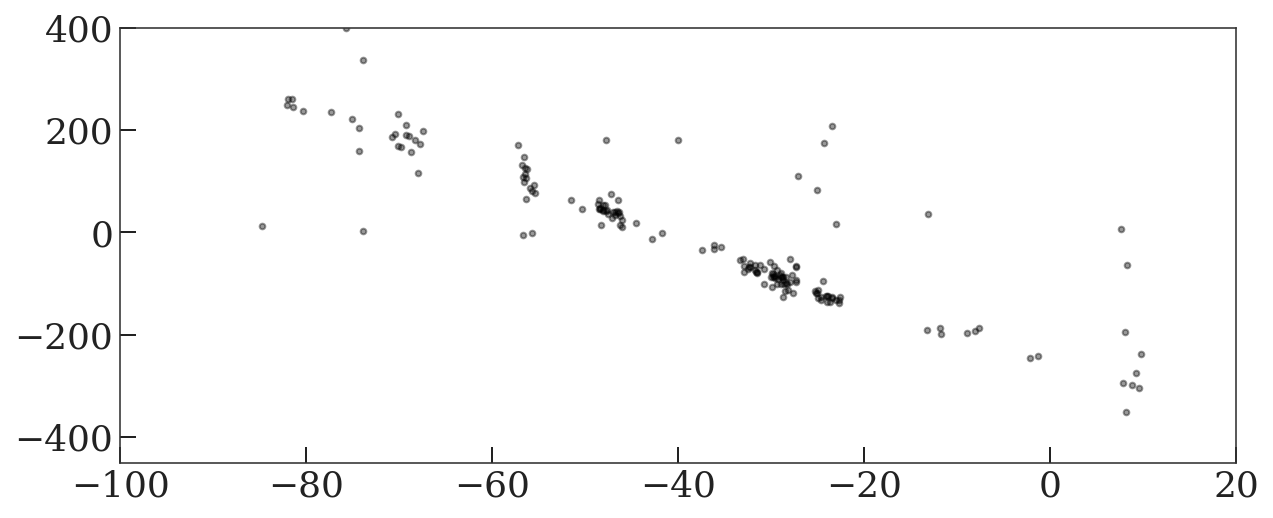

In [60]:
plt.figure(figsize=(10, 4))
plt.scatter(segue_joined['gd1_phi1'], segue_joined['gd1_rv'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## LAMOST

In [61]:
lamost = at.Table.read('/mnt/home/apricewhelan/data/LAMOST/DDPayne_LAMOST-DR5_recommend.fits')

In [62]:
lamost_c = coord.SkyCoord(lamost['RA'], lamost['DEC'], unit=u.deg)

In [63]:
lamost_idx, lamost_sep, _ = c.match_to_catalog_sky(lamost_c)
sep_mask = (lamost_sep < 2*u.arcsec)
lamost_joined = at.hstack((g.data[sep_mask], lamost[lamost_idx[sep_mask]]))
lamost_joined = lamost_joined[np.isfinite(lamost_joined['RV'])]
lamost_joined['gd1_rv'] = lamost_joined['RV']
lamost_joined['gd1_rv_err'] = lamost_joined['RV_ERR']
all_joined['lamost'] = lamost_joined

(-450.0, 400.0)

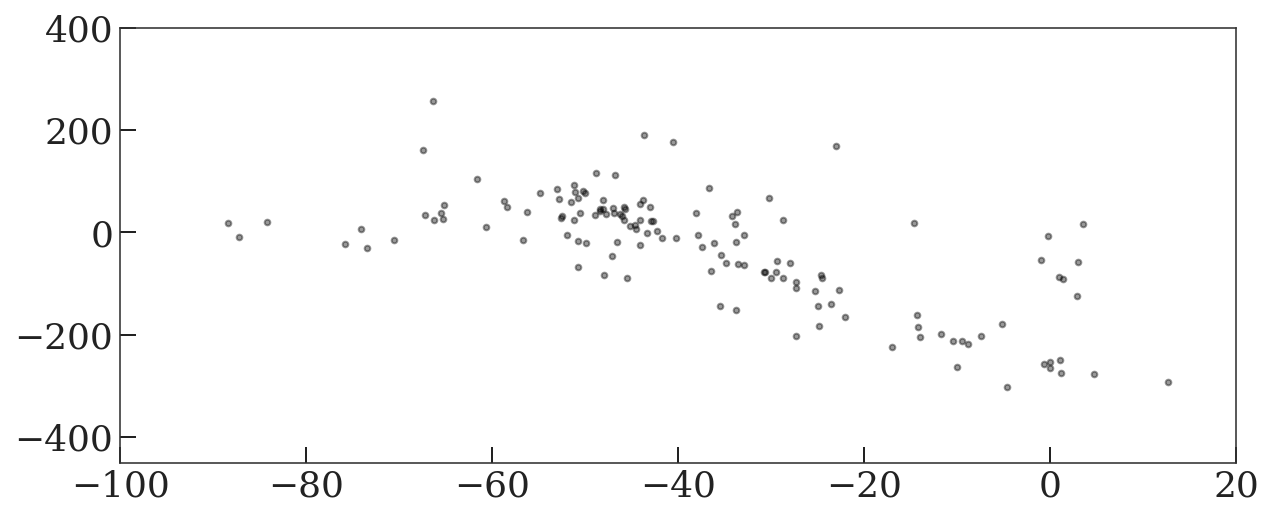

In [64]:
plt.figure(figsize=(10, 4))
plt.scatter(lamost_joined['gd1_phi1'], lamost_joined['RV'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## Hectospec

In [65]:
hecto = at.Table.read('../data/hecto-catalog.fits')

In [66]:
hecto_c = coord.SkyCoord(hecto['ra'], hecto['dec'], unit=u.deg)

In [67]:
hecto_idx, hecto_sep, _ = c.match_to_catalog_sky(hecto_c)
sep_mask = (hecto_sep < 2*u.arcsec)
hecto_joined = at.hstack(
    (g.data[sep_mask], hecto[hecto_idx[sep_mask]]),
    uniq_col_name='{col_name}{table_name}',
    table_names=['', '_2']
)
hecto_joined = hecto_joined[np.isfinite(hecto_joined['Vrad'])]
hecto_joined['gd1_rv'] = hecto_joined['Vrad']
hecto_joined['gd1_rv_err'] = hecto_joined['std_Vrad']
all_joined['hecto'] = hecto_joined

(-450.0, 400.0)

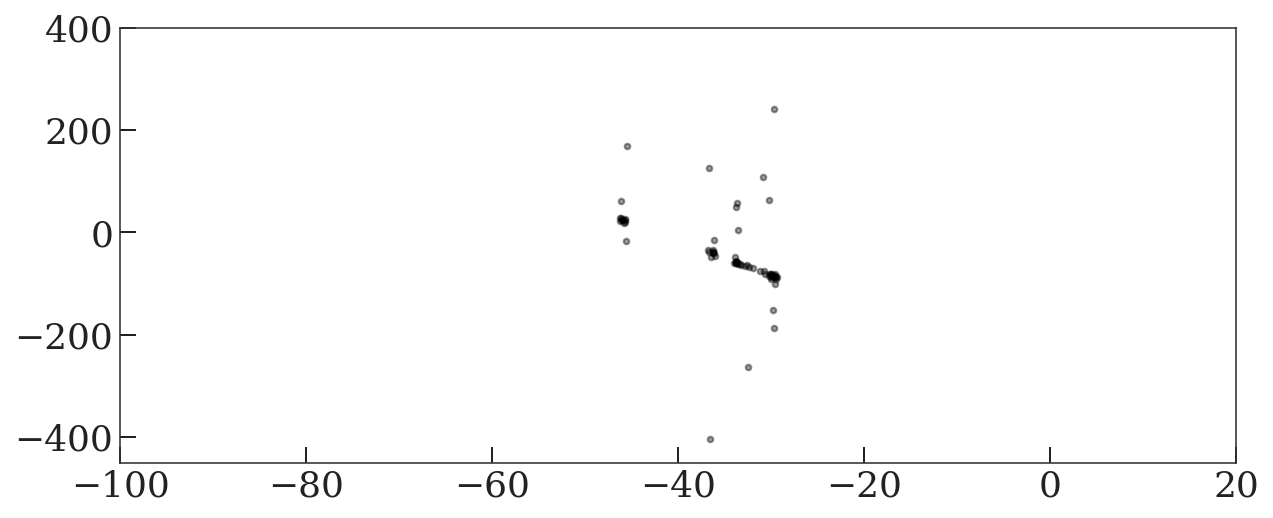

In [68]:
plt.figure(figsize=(10, 4))
plt.scatter(hecto_joined['gd1_phi1'], hecto_joined['Vrad'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## All combined

In [69]:
for i, name in enumerate(all_joined.keys()):
    all_joined[name]['survey_id'] = i
    all_joined[name]['survey_name'] = name

In [70]:
all_stacked = at.vstack(list(all_joined.values()))
assert np.isfinite(all_stacked['gd1_rv']).all()
len(all_stacked)

701

In [71]:
remove_cols = []
for name in all_stacked.colnames:
    if all_stacked[name].dtype == np.dtype('O'):
        remove_cols.append(name)
all_stacked.remove_columns(remove_cols)

In [69]:
c = coord.SkyCoord(
    all_stacked['gd1_phi1'], 
    all_stacked['gd1_phi2'], 
    unit=u.deg, 
    frame=gc.GD1Koposov10()
)
vgsr = gc.vhel_to_vgsr(c, all_stacked['gd1_rv'], galcen_frame.galcen_v_sun.d_xyz)
all_stacked['v_gsr'] = vgsr

In [70]:
all_stacked.write(cache_path / 'all_spectro.fits', overwrite=True)

In [71]:
np.unique(all_stacked['source_id']).size

433

(-500.0, 500.0)

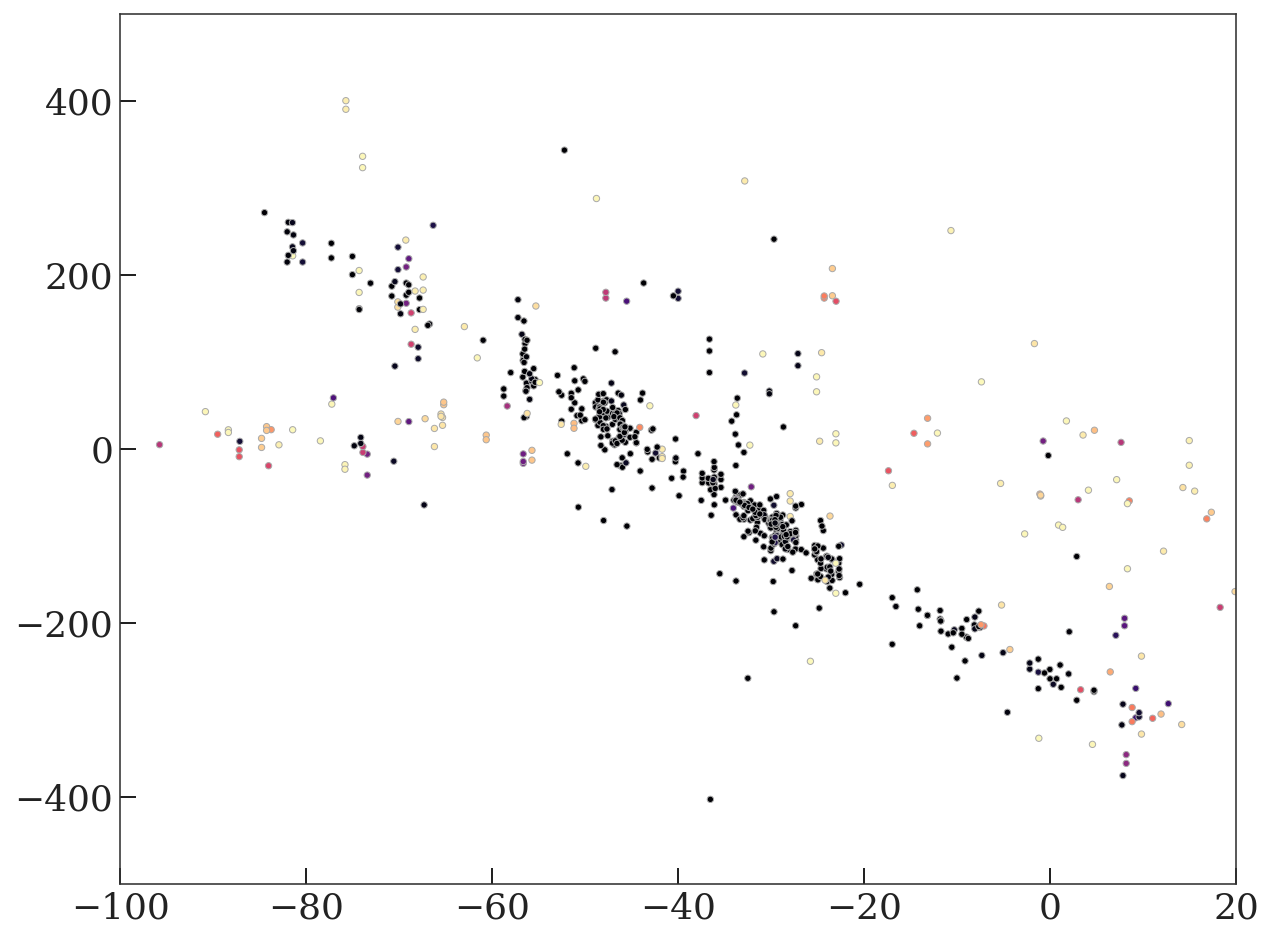

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    all_stacked['gd1_phi1'],
    all_stacked['gd1_rv'],
    c=all_stacked['member_prob'],
    vmin=0, 
    vmax=1,
    cmap='magma_r',
    s=10,
    linewidth=0.5, edgecolor='#aaaaaa'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 500)

(-500.0, 500.0)

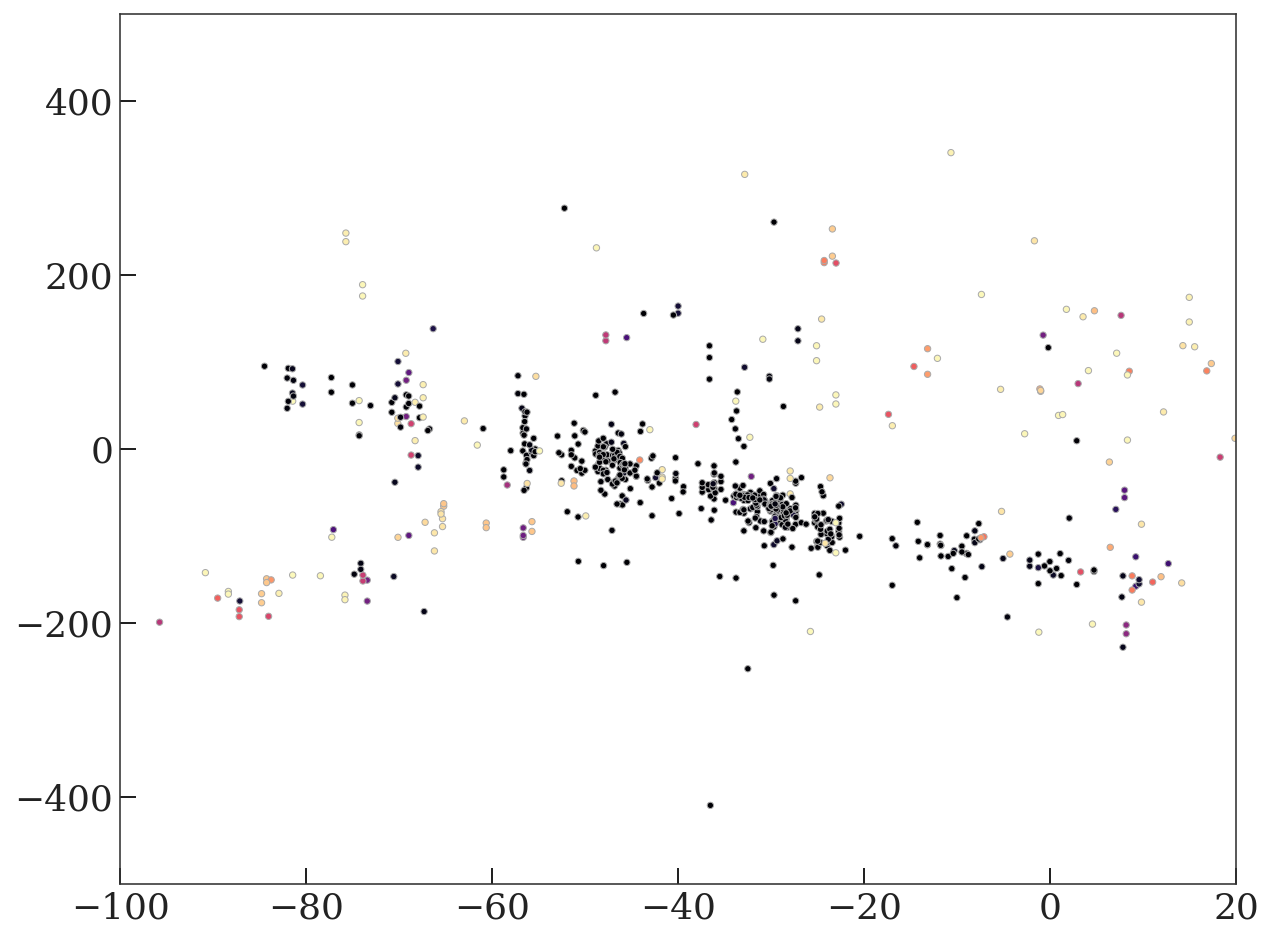

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    all_stacked['gd1_phi1'],
    all_stacked['v_gsr'],
    c=all_stacked['member_prob'],
    vmin=0, 
    vmax=1,
    cmap='magma_r',
    s=10,
    linewidth=0.5, edgecolor='#aaaaaa'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 500)

(-500.0, 400.0)

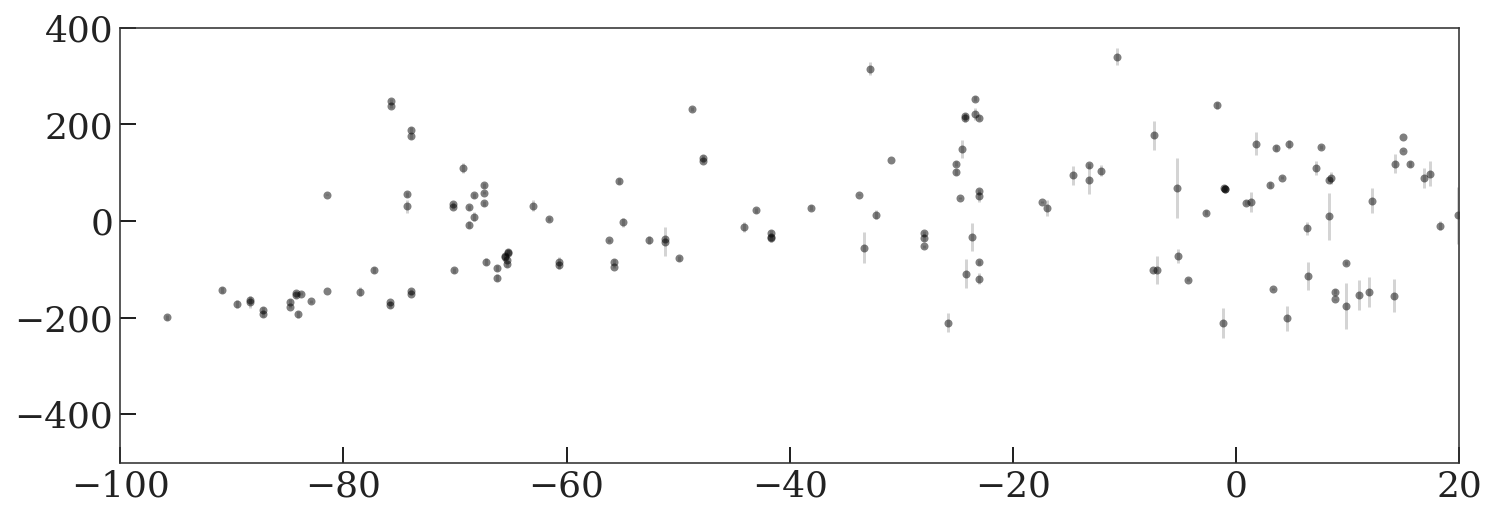

In [75]:
# _strict = (all_stacked['member_prob'] > 0.01)
_strict = (all_stacked['member_prob'] < 0.5)

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(
    all_stacked['gd1_phi1'][_strict],
    all_stacked['v_gsr'][_strict],
    all_stacked['gd1_rv_err'][_strict],
    ls='none',
    marker='o',
    ecolor='#aaaaaa',
    alpha=0.5,
    ms=4
)
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 400)

# RV membership

In [76]:
import pathlib
import pickle

import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy.ndimage as scn
import scipy.interpolate as sci
import scipy.optimize as sco

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci
import blackjax

# from gd1_helpers.membership.rv import RVStreamModel, RVBackgroundModel, RVJointModel
from gd1_helpers.membership.rv import RVStreamModel, RVBackgroundModel, RVMixtureModel

In [77]:
data_path = pathlib.Path('../data').resolve().absolute()
cache_path = pathlib.Path('../cache').resolve().absolute()

In [78]:
all_stacked = at.Table.read(cache_path / 'all_spectro.fits')
lenient_mask = all_stacked['member_prob'] > 0.1
strict_mask = all_stacked['member_prob'] > 0.8

In [79]:
with open(cache_path / 'fiducial_rv_spline.pkl', 'rb') as f:
    fiducial_spl = pickle.load(f)

In [91]:
data = {
    'survey_id': all_stacked['survey_id'],
    'phi1': all_stacked['gd1_phi1'],
    # 'rv': all_stacked['gd1_rv'],
    'rv': all_stacked['v_gsr'],
    'rv_error': np.sqrt(all_stacked['gd1_rv_err']**2 + 0.1**2),
}

for k in data:
    if k == 'survey_id':
        data[k] = np.array(data[k], dtype=np.int32, copy=True)
    else:
        data[k] = np.array(data[k], dtype=np.float64, copy=True)
        
    assert np.all(np.isfinite(data[k]))

Text(0.5, 0, '$\\phi_1$')

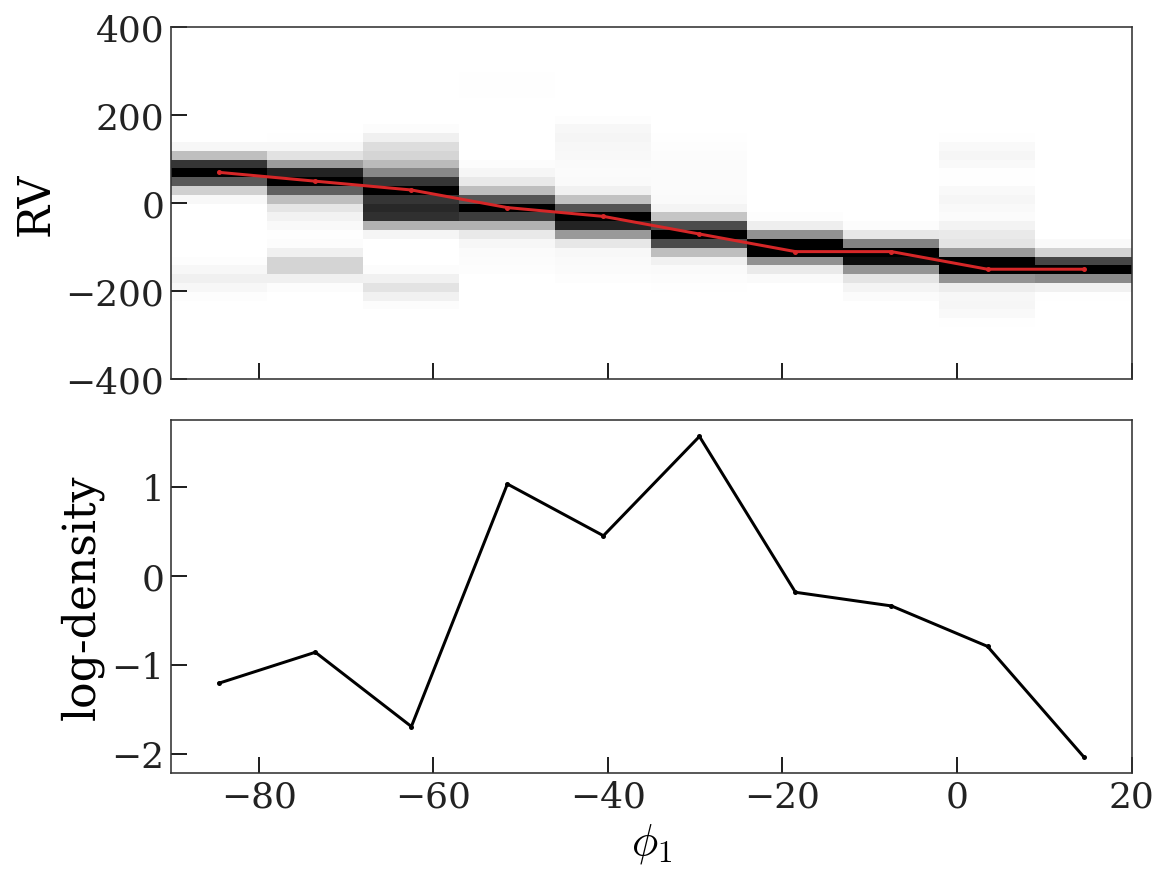

In [84]:
H, xe, ye = np.histogram2d(
    data['phi1'][strict_mask],
    data['rv'][strict_mask],
    bins=(np.linspace(-90, 20 + 1e-3, 11), np.arange(-400, 400 + 1e-3, 20)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H /= (xe[1] - xe[0])
H_density = H.copy()

peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]
H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
axes[0].plot(xc, yc[peak_idx], color="tab:red")
axes[0].set_ylabel("RV")

axes[1].plot(xc, H_ln_density)
axes[1].set_ylabel(r"log-density")
axes[1].set_xlabel(r"$\phi_1$")

In [85]:
stream_init_p = {}
# stream_init_p['ln_n0'] = sci.InterpolatedUnivariateSpline(xc, H_ln_density, k=1)(RVStreamModel.ln_n0_knots)
stream_init_p['mean_rv'] = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx], k=1)(
    RVStreamModel.rv_knots
)
# stream_init_p["ln_std_rv"] = np.full_like(stream_init_p['mean_rv'], 0)
# RVStreamModel.ln_likelihood(stream_init_p, data)

Text(0.5, 0, '$\\phi_1$')

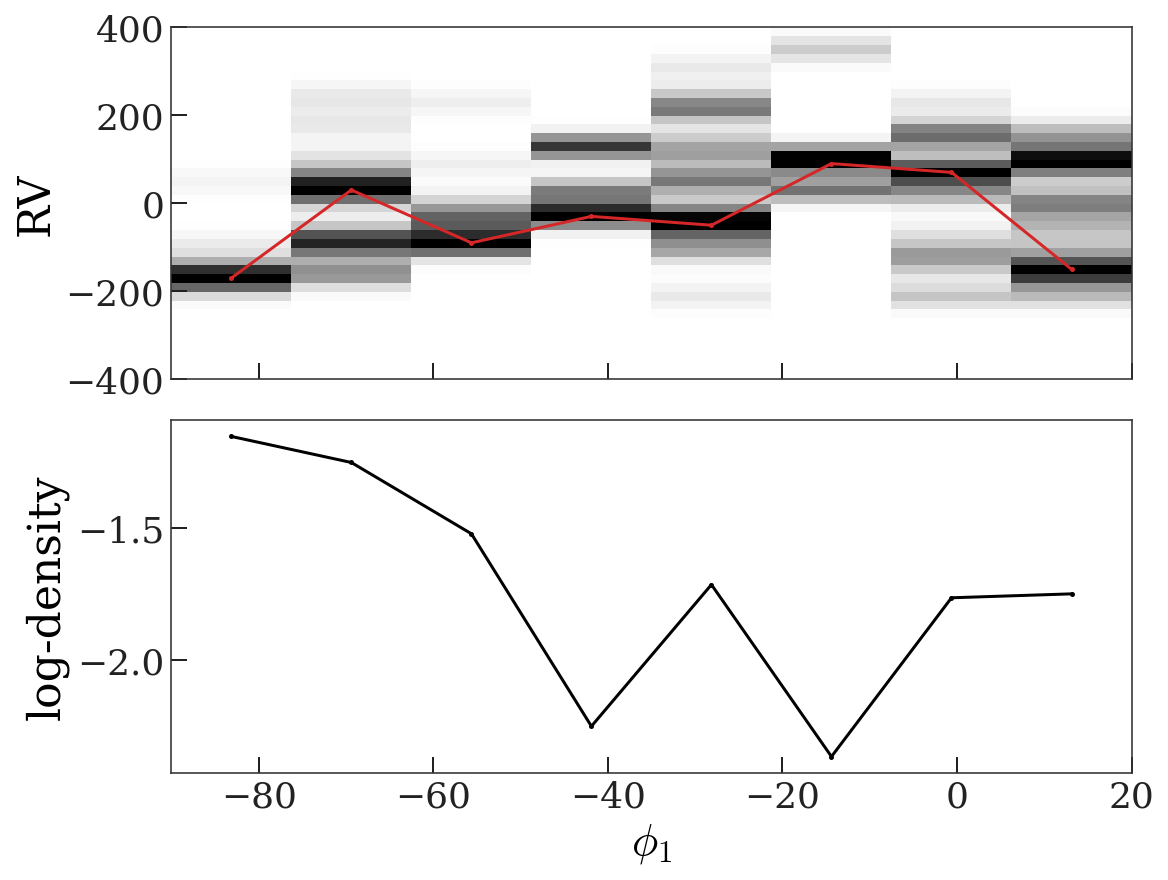

In [86]:
H, xe, ye = np.histogram2d(
    data['phi1'][~strict_mask],
    data['rv'][~strict_mask],
    bins=(np.linspace(-90, 20 + 1e-3, 9), 
          np.arange(-400, 400 + 1e-3, 20)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H /= (xe[1] - xe[0])
H_density = H.copy()

peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]
bg_H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
axes[0].plot(xc, yc[peak_idx], color="tab:red")
axes[0].set_ylabel("RV")

axes[1].plot(xc, bg_H_ln_density)
axes[1].set_ylabel(r"log-density")
axes[1].set_xlabel(r"$\phi_1$")

In [102]:
bkg_init_p = {}
# bkg_init_p['ln_n0'] = sci.InterpolatedUnivariateSpline(xc, bg_H_ln_density, k=1)(RVBackgroundModel.ln_n0_knots)
# bkg_init_p['ln_n0'] = np.full_like(RVBackgroundModel.ln_n0_knots, stream_init_p['ln_n0'].min() - 1)
bkg_init_p['arctanh_w'] = np.full_like(RVBackgroundModel.rv_knots, 0.)
bkg_init_p['mean1'] = np.full_like(RVBackgroundModel.rv_knots, 0.)
bkg_init_p['mean2'] = np.full_like(RVBackgroundModel.rv_knots, 0.)
bkg_init_p['ln_std1'] = np.full_like(RVBackgroundModel.rv_knots, np.log(25))
bkg_init_p['ln_std2'] = np.full_like(RVBackgroundModel.rv_knots, np.log(100))

# RVBackgroundModel.ln_likelihood(bkg_init_p, data)

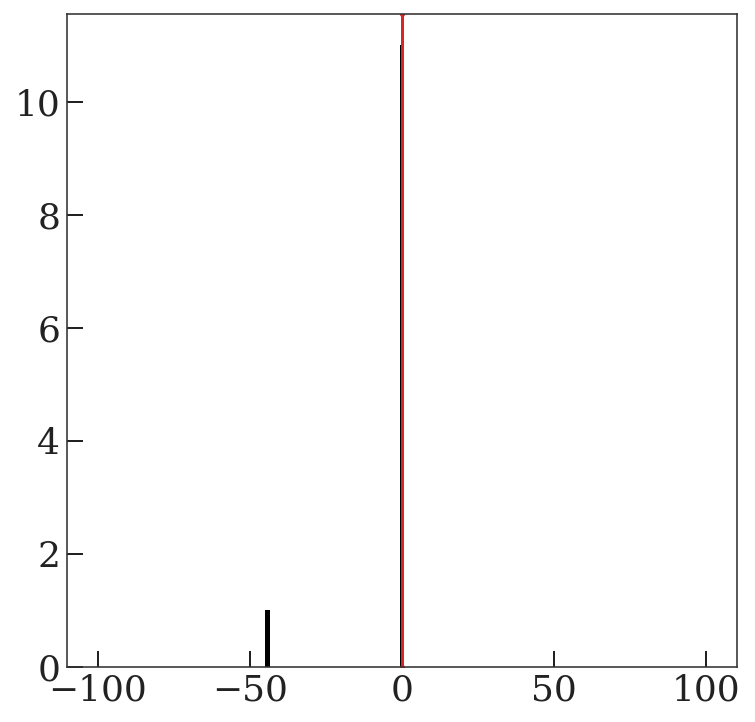

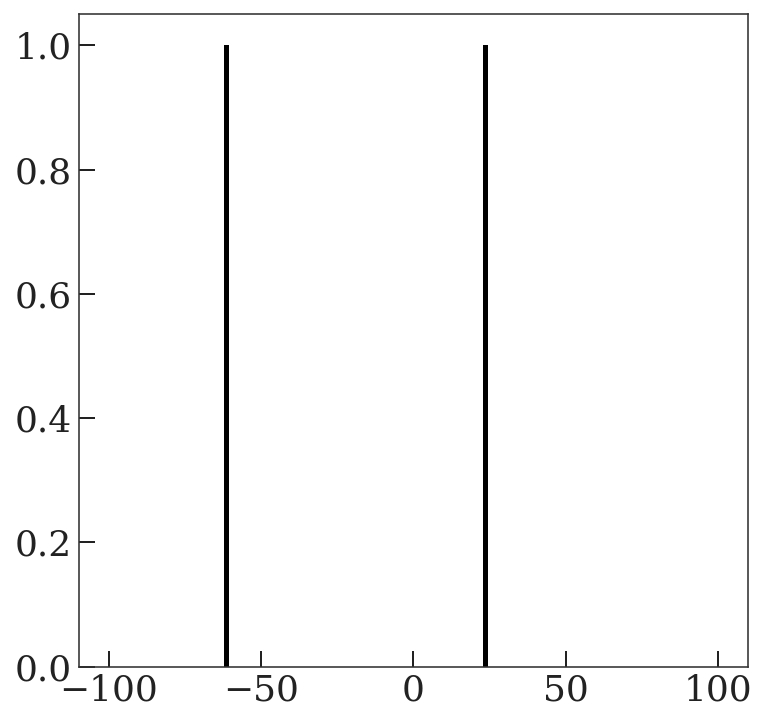

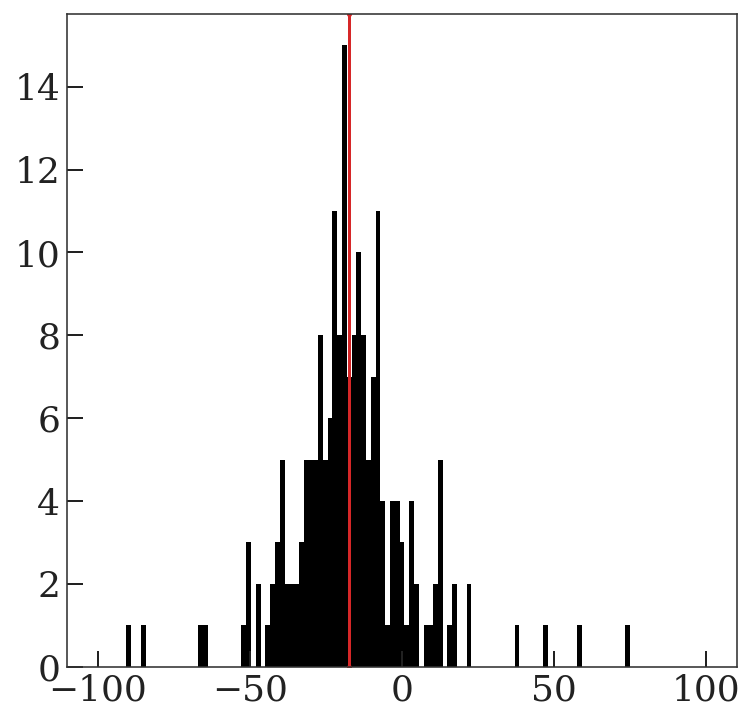

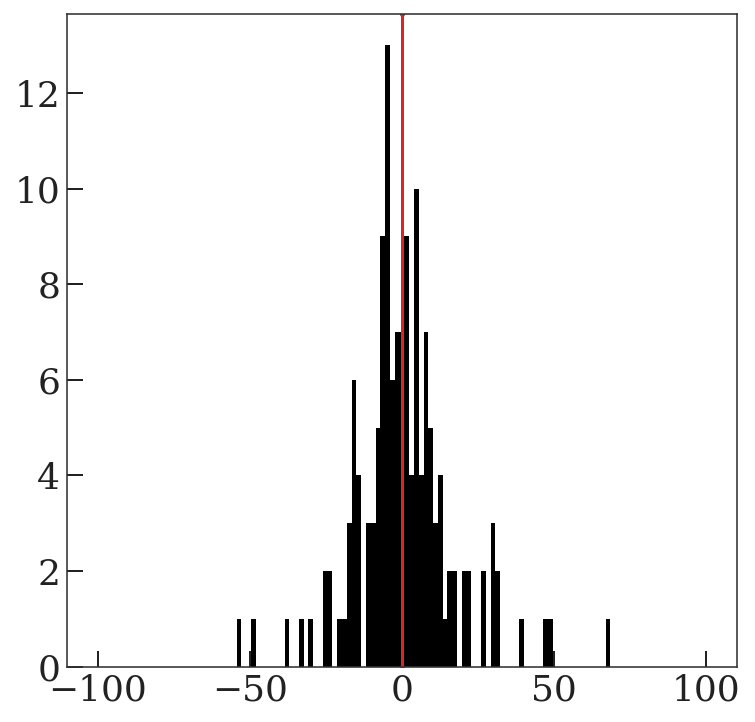

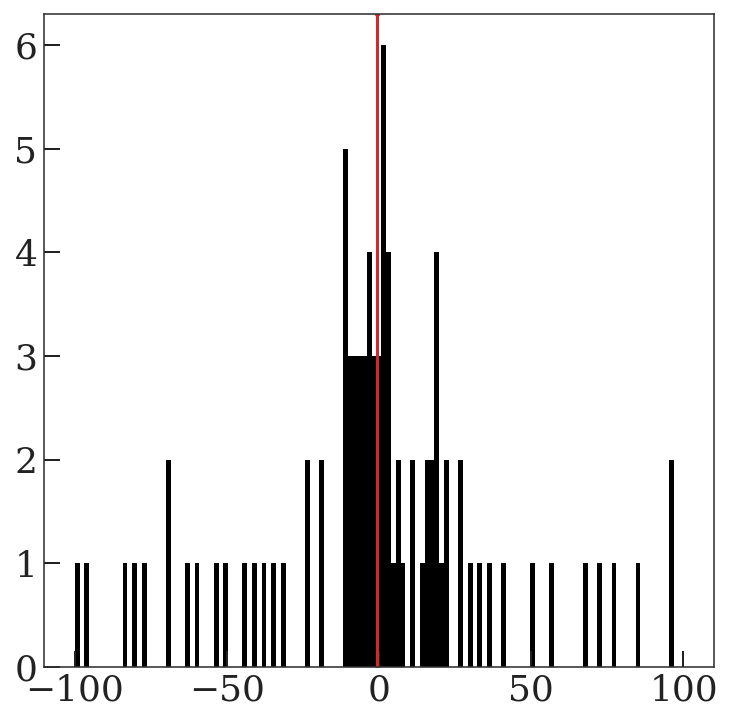

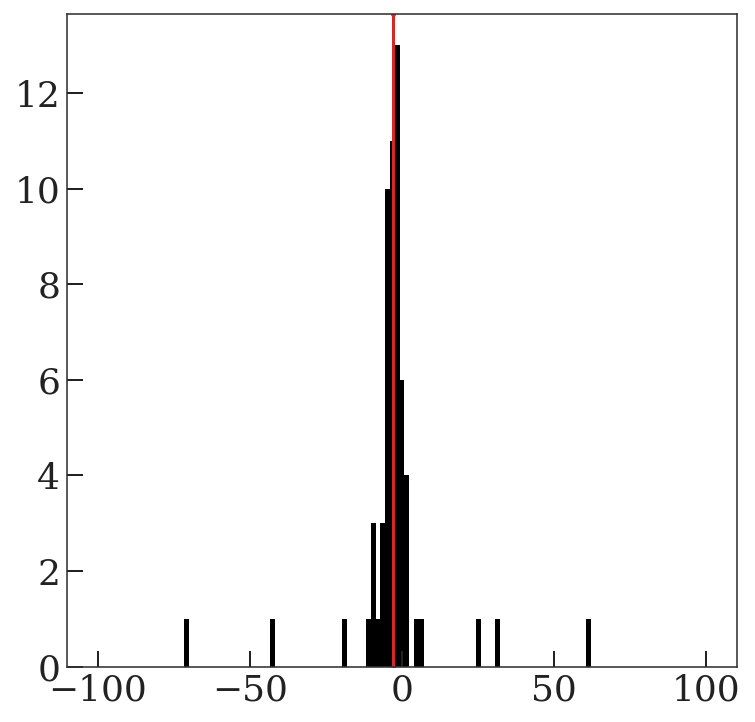

In [103]:
rv0 = np.zeros(np.unique(all_stacked['survey_id']).size)
for i in np.unique(all_stacked['survey_id']):
    _mask = (all_stacked['survey_id'] == i) & (all_stacked['member_prob'] > 0.8)
    drv = all_stacked['gd1_rv'][_mask] - fiducial_spl(all_stacked['gd1_phi1'][_mask])
    plt.figure()
    plt.hist(drv,
             bins=np.linspace(-100, 100, 128))
    if len(drv) > 10:
        rv0[i] = np.median(drv)
        plt.axvline(np.median(drv), color='tab:red')

In [104]:
offset_init_p = {'rv0': -rv0}
print(rv0)
# RVOffsetModel.ln_likelihood(stream_init_p, data)

[  0.           0.         -17.50317608   0.09894786  -0.75798459
  -2.92310586]


In [105]:
for i in range(len(rv0)):
    _mask = data['survey_id'] == i
    data['rv'][_mask] = data['rv'][_mask] - rv0[i]

(-500.0, 500.0)

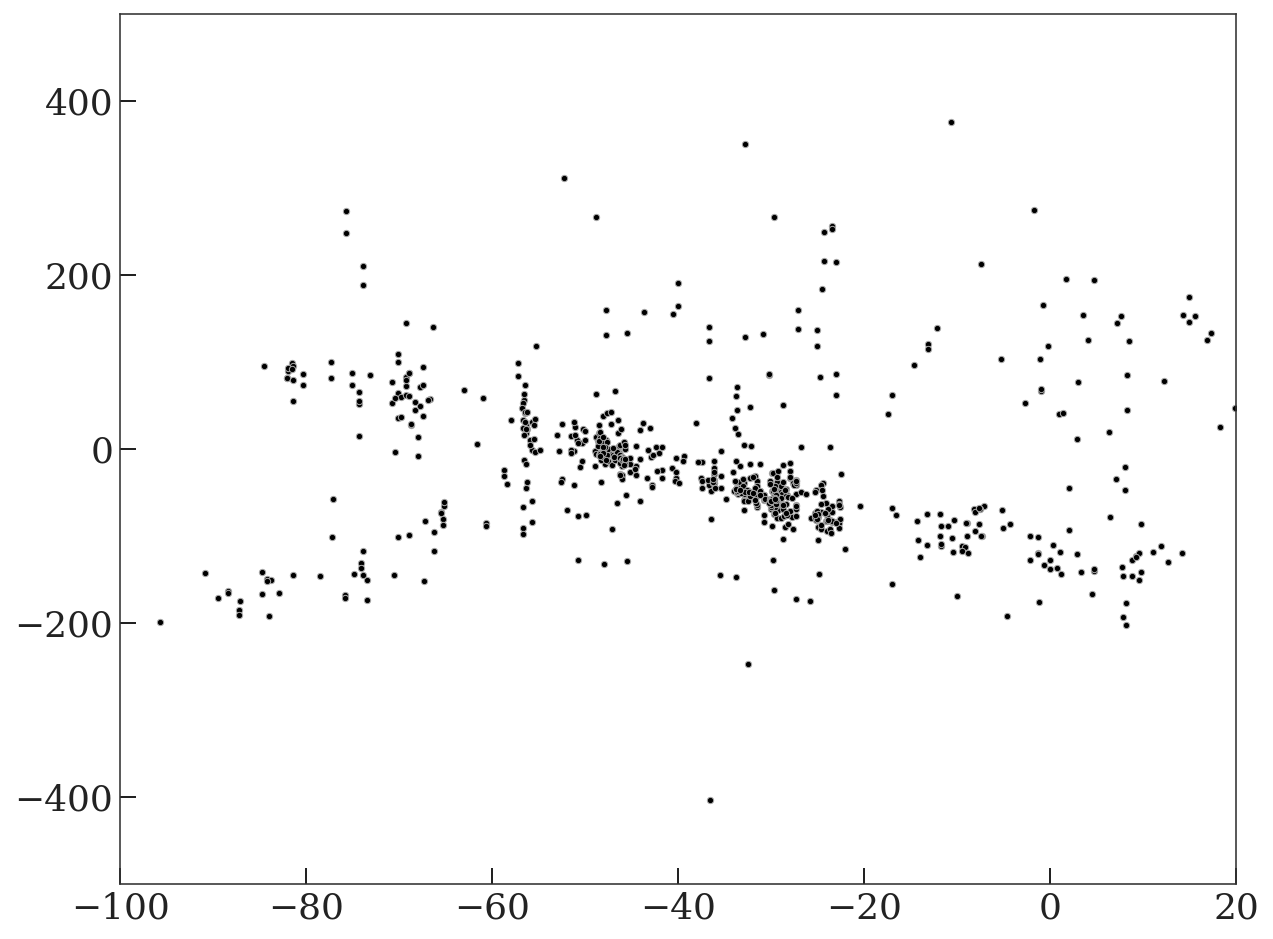

In [106]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    data['phi1'],
    data['rv'],
    vmin=0, 
    vmax=1,
    s=10,
    linewidth=0.5, edgecolor='#aaaaaa'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 500)

In [107]:
# rv0 = np.zeros(np.unique(all_stacked['survey_id']).size)
# for i in np.unique(all_stacked['survey_id']):
#     _mask = (all_stacked['survey_id'] == i) & (all_stacked['member_prob'] > 0.8)
#     drv = data['rv'][_mask] - fiducial_spl(data['phi1'][_mask])
#     plt.figure()
#     plt.hist(drv,
#              bins=np.linspace(-100, 100, 128))
#     if len(drv) > 10:
#         rv0[i] = np.median(drv)
#         plt.axvline(np.median(drv), color='tab:red')

In [156]:
from copy import deepcopy
from functools import partial

import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

from gd1_helpers.membership import Model, JointModel
from gd1_helpers.membership.helpers import (
    ln_normal,
    ln_simpson,
    ln_truncated_normal,
    ln_uniform,
    two_norm_mixture_ln_prob,
)


class RVStreamModel(Model):
    name = "stream"

    rv_knots = jnp.linspace(-110, 30, 5)
    param_names = {
        "mean_rv": len(rv_knots),
    }
    param_bounds = {
        "mean_rv": (-800, 800),
    }

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def rv(cls, data, pars):
        """ln_likelihood for rv"""
        # TODO: different extra error for each survey - maybe add at RVMixtureModel level?
        mean_spl = InterpolatedUnivariateSpline(cls.rv_knots, pars["mean_rv"], k=3)
        return ln_normal(
            data["rv"],
            mean_spl(data["phi1"]),
            0.5 ** 2 + data["rv_error"] ** 2,
        )

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_likelihood(cls, pars, data):
        return cls.rv(data, pars)

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_prior(cls, pars):
        lp = 0.0

#         prior_stds = {
#             "mean_rv": 50.,
#             "ln_std_rv": 0.5,
#         }
#         for name, size in cls.param_names.items():
#             if name not in prior_stds:
#                 continue

#             for i in range(1, size):
#                 lp += ln_normal(pars[name][i], pars[name][i - 1], prior_stds[name])

#         for name in ["mean_rv", "ln_std_rv"]:
#             lp += ln_uniform(pars[name], *cls.param_bounds[name]).sum()

        return lp


class RVBackgroundModel(Model):
    name = "background"

    rv_knots = jnp.linspace(-110, 30, 7)
    param_names = {
        "arctanh_w": len(rv_knots),
        "mean1": len(rv_knots),
        "mean2": len(rv_knots),
        "ln_std1": len(rv_knots),
        "ln_std2": len(rv_knots),
    }
    param_bounds = {
        "arctanh_w": (-100, 100),
        "mean1": (-500, 500),
        "mean2": (-500, 500),
        "ln_std1": (-5, 5),
        "ln_std2": (-5, 8),
    }

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def rv(cls, data, pars):
        """ln_likelihood for rv"""
        arctanh_w_spl = InterpolatedUnivariateSpline(cls.rv_knots, pars["arctanh_w"], k=3)
        mean1_spl = InterpolatedUnivariateSpline(cls.rv_knots, pars["mean1"], k=3)
        ln_std1_spl = InterpolatedUnivariateSpline(
            cls.rv_knots, pars["ln_std1"], k=3
        )
        mean2_spl = InterpolatedUnivariateSpline(cls.rv_knots, pars["mean2"], k=3)
        ln_std2_spl = InterpolatedUnivariateSpline(
            cls.rv_knots, pars["ln_std2"], k=3
        )

        w = 0.5 * (jnp.tanh(arctanh_w_spl(data["phi1"])) + 1)
        p = jnp.stack(
            (
                w,
                mean1_spl(data["phi1"]),
                mean2_spl(data["phi1"]),
                ln_std1_spl(data["phi1"]),
                ln_std2_spl(data["phi1"]),
            )
        )
        return two_norm_mixture_ln_prob(p, data["rv"], data["rv_error"])

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_likelihood(cls, pars, data):
        return cls.rv(data, pars)

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_prior(cls, pars):
        lp = 0.0

        prior_stds = {
            "mean1": 50.0,
            "ln_std1": 0.5,
            "mean2": 50.0,
            "ln_std2": 0.5,
        }
        for name, size in cls.param_names.items():
            if name not in prior_stds:
                continue

            for i in range(1, size):
                lp += ln_normal(pars[name][i], pars[name][i - 1], prior_stds[name]**2)
                
        lp += (-jnp.log(jnp.cosh(pars['arctanh_w'])**2) - jnp.log(2)).sum()

        return lp

In [187]:
from functools import partial

import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

from gd1_helpers.membership import JointModel


class RVMixtureModel(JointModel):
    components = {
        ModelComponent.name: ModelComponent
        for ModelComponent in [RVBackgroundModel, RVStreamModel]
    }

    w_mix_knots = jnp.arange(-110, 30+1e-3, 30)
    param_names = {
        'arctanh_w_mix': len(w_mix_knots)
    }
    param_bounds = {
        'arctanh_w_mix': (-100, 100)
    }
    for component_name, ModelComponent in components.items():
        for k, v in ModelComponent.param_names.items():
            param_names[k + f"_{ModelComponent.name}"] = v

    print(f"model has {sum(param_names.values())} parameters")

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_likelihood(cls, flat_pars, data):
        component_pars = cls.unpack_component_pars(flat_pars)

        lls = []
        for name, Component in cls.components.items():
            lln = Component.ln_likelihood(component_pars[name], data)
            lls.append(lln)

        arctanh_w_spl = InterpolatedUnivariateSpline(
            cls.w_mix_knots, flat_pars["arctanh_w_mix"], k=3
        )
        w = 0.5 * (jnp.tanh(arctanh_w_spl(data['phi1'])) + 1)
        # b = [w, 1 - w]
        # return logsumexp(jnp.array(lls), b=jnp.array(b), axis=0)
        return jnp.logaddexp(jnp.log(w) + lls[0], jnp.log(1 - w) + lls[1])

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_prior(cls, flat_pars):
        component_pars = cls.unpack_component_pars(flat_pars)

        lp = 0.0
        for name, Component in cls.components.items():
            lp += Component.ln_prior(component_pars[name])
            
        lp += (-jnp.log(jnp.cosh(flat_pars['arctanh_w_mix'])**2) - jnp.log(2)).sum()
            
        return lp

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_posterior(cls, pars_arr, data, *args):
        pars = cls.unpack_pars(pars_arr)
        ln_L = cls.ln_likelihood(pars, data, *args)
        return ln_L.sum() + cls.ln_prior(pars)

model has 45 parameters


In [189]:
init_pars = {
    RVStreamModel.name: stream_init_p, 
    RVBackgroundModel.name: bkg_init_p,
#     RVOffsetModel.name: offset_init_p
    'arctanh_w_mix': np.full_like(RVMixtureModel.w_mix_knots, 0.)
}

# flat_init_pars = RVJointModel.pack_component_pars(init_pars)
# flat_init_p = RVJointModel.pack_pars(flat_init_pars)
flat_init_pars = RVMixtureModel.pack_component_pars(init_pars)
flat_init_p = RVMixtureModel.pack_pars(flat_init_pars)
flat_init_p.size

45

In [190]:
# RVMixtureModel.ln_likelihood(flat_init_pars, data)

In [191]:
# RVMixtureModel.ln_prior(flat_init_pars)

In [192]:
RVMixtureModel.objective(flat_init_p, len(data['phi1']), data)

DeviceArray(5.96814755, dtype=float64)

In [193]:
param_bounds = {}
for Component in RVMixtureModel.components.values():
    for k, v in Component.param_bounds.items():
        param_bounds[f'{k}_{Component.name}'] = v
param_bounds.update(RVMixtureModel.param_bounds)

_tmp_l = RVMixtureModel.pack_pars(
    {k: np.full(RVMixtureModel.param_names[k], v[0], dtype='f8') 
     for k, v in param_bounds.items() if k in RVMixtureModel.param_names}
)
_tmp_r = RVMixtureModel.pack_pars(
    {k: np.full(RVMixtureModel.param_names[k], v[1], dtype='f8')
    for k, v in param_bounds.items() if k in RVMixtureModel.param_names}
)
bounds = np.stack((_tmp_l, _tmp_r)).T
assert bounds.shape[0] == flat_init_p.shape[0]

Check that all initial paramter values are in bounds

In [194]:
flat_init_pars

{'arctanh_w_background': DeviceArray([0., 0., 0., 0., 0., 0., 0.], dtype=float64),
 'arctanh_w_mix': DeviceArray([0., 0., 0., 0., 0.], dtype=float64),
 'ln_std1_background': DeviceArray([3.21887582, 3.21887582, 3.21887582, 3.21887582, 3.21887582,
              3.21887582, 3.21887582], dtype=float64),
 'ln_std2_background': DeviceArray([4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
              4.60517019, 4.60517019], dtype=float64),
 'mean1_background': DeviceArray([0., 0., 0., 0., 0., 0., 0.], dtype=float64),
 'mean2_background': DeviceArray([0., 0., 0., 0., 0., 0., 0.], dtype=float64),
 'mean_rv_stream': DeviceArray([ 116.36330579,   52.72752066,  -31.81652894, -119.0880992 ,
              -150.        ], dtype=float64)}

In [195]:
for k in RVMixtureModel.param_names:
    check = (
        (flat_init_pars[k] >= param_bounds[k][0]) &
        (flat_init_pars[k] <= param_bounds[k][1])
    )
    if not np.all(check):
        print(k, flat_init_pars[k])

## Run optimizer

In [196]:
data.pop('survey_id', None);

In [197]:
obj_grad = jax.jit(jax.grad(RVMixtureModel.objective))
run_res = sco.minimize(
    RVMixtureModel.objective, 
    x0=np.array(flat_init_p, dtype=np.float64),
    jac=lambda x, *args: np.array(obj_grad(x, *args), dtype=np.float64),
    method='l-bfgs-b',
    bounds=bounds,
    args=(len(data['phi1']), data),
    options=dict(maxiter=100_000, maxls=1000)
)
run_res


# obj_grad = jax.jit(jax.grad(RVMixtureModel.objective))
# def _jac(x, *args):
#     print(list(np.array(x)))
#     return np.array(obj_grad(x, *args), dtype=np.float64)
    
# run_res = sco.minimize(
#     RVMixtureModel.objective, 
#     x0=np.array(flat_init_p, dtype=np.float64),
#     jac=_jac,
#     method='l-bfgs-b',
#     bounds=bounds,
#     args=(len(data['phi1']), data),
#     options=dict(maxiter=100_000, maxls=1000)
# )
# run_res

      fun: 5.353405272047778
 hess_inv: <45x45 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.48458069e-07, -7.30455072e-07, -4.70642122e-06,  1.64995049e-06,
        4.73619003e-06,  2.79582928e-06,  3.63650505e-06,  9.21371119e-07,
        3.00920375e-06, -9.01330511e-07,  1.67781651e-06,  2.03990461e-06,
        2.47500618e-06,  2.22743520e-06,  1.20561592e-06, -1.89360935e-06,
       -7.64379088e-06,  2.15723137e-06,  1.80466242e-06, -4.80783745e-06,
       -2.90611862e-06, -1.44565465e-06, -8.46740080e-07, -4.10250041e-07,
       -2.32168756e-06, -6.71083294e-07,  8.06662976e-06,  6.30785697e-06,
        3.64423622e-07, -1.62595748e-06,  1.02239756e-06,  6.46853043e-07,
        2.93342864e-06,  1.89364736e-06,  2.85234707e-06, -1.09017201e-07,
        1.44460202e-06,  2.83797400e-06, -1.78234135e-06, -1.72916849e-06,
       -2.95098961e-06, -3.59089720e-06,  5.02315324e-07, -6.93924002e-06,
       -9.41434090e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_

In [198]:
opt_pars = RVMixtureModel.unpack_component_pars(RVMixtureModel.unpack_pars(run_res.x))

# fail_x = np.array([-0.02957507124301449, 1.4379779684012397, 0.48425230712179645, -0.03769325791841171, 0.8482712558751321, 0.056560328007213, -1.3308073410202688, -0.42179330807362003, 1.3392809621257786, -0.7975743652117689, -1.1362218812025673, -0.05620263014189426, -4.559306184835488e-05, 0.002032678875560345, 0.03496993567174979, -0.06881831530472546, -0.04640718504980975, 0.009008357015544241, -6.720419972995847e-05, -0.0003098377943080572, -0.008633980100916153, -0.0002419939848562444, -0.0020122638366151372, -0.003837321845543841, 0.00498985858344022, 0.000796393686284305, 3.217608661739025, 3.6556313589317515, 3.85048695155093, 3.5118820005548743, 5.0, 3.393765031996945, 3.255689887758782, 4.725047988475092, 4.8668343436416315, 4.960925323683192, 5.561128785178868, 5.1972996335726185, 4.859357545327325, 4.724584323447197, 116.35954841316453, 52.842504629107545, -31.479246512240895, -119.394420399174, -150.00452032674926])
# opt_pars = RVMixtureModel.unpack_component_pars(RVMixtureModel.unpack_pars(fail_x))

In [199]:
# shit = RVMixtureModel.ln_likelihood(RVMixtureModel.unpack_pars(fail_x), data)

In [200]:
opt_pars['stream']

{'mean_rv': DeviceArray([ 160.13545463,   69.27144638,  -28.70637993, -126.42389379,
              -139.08664733], dtype=float64)}

In [201]:
opt_pars['background']

{'arctanh_w': DeviceArray([ 0.28288712,  0.56114294,  1.01743674,  0.636045  ,
               0.43035213, -0.45926593, -0.26577371], dtype=float64),
 'ln_std1': DeviceArray([3.34319129, 3.52227889, 4.35238022, 2.72849343, 2.90447396,
              2.0863007 , 2.13530383], dtype=float64),
 'ln_std2': DeviceArray([5.05861606, 4.99033241, 5.58944107, 5.24218503, 5.42212766,
              4.69094343, 4.73076937], dtype=float64),
 'mean1': DeviceArray([-137.69638073, -159.79625008,   -2.66281209,  -25.10338402,
               -83.85304627, -119.07351886, -161.39671665], dtype=float64),
 'mean2': DeviceArray([ 3.78573451, 14.6423193 , 18.81128655, 12.59838865,
              26.45315734, 55.83762792, 69.42382462], dtype=float64)}

In [202]:
opt_pars['arctanh_w_mix']

DeviceArray([0.09003401, 0.49064481, 0.4980395 , 0.53926135, 0.67059367],            dtype=float64)

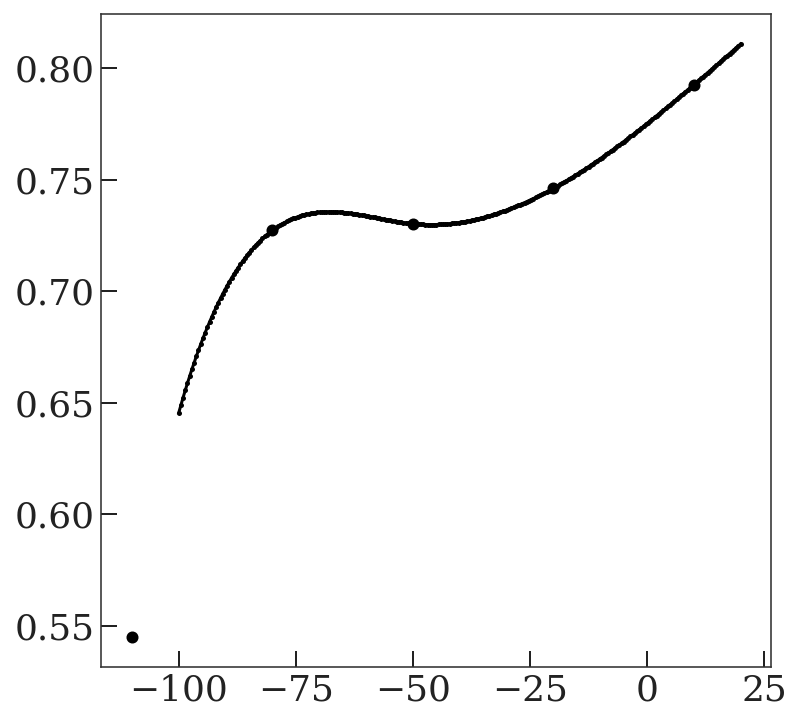

In [204]:
tmp = sci.InterpolatedUnivariateSpline(
    RVMixtureModel.w_mix_knots,
    opt_pars['arctanh_w_mix'],
    k=3
)

_grid = np.linspace(-100, 20, 256)
tmp_w = (np.tanh(tmp(_grid)) + 1) / 2

plt.plot(_grid, tmp_w)
plt.scatter(RVMixtureModel.w_mix_knots, (np.tanh(opt_pars['arctanh_w_mix']) + 1) / 2)

In [35]:
# opt_pars['offset']

(-500.0, 400.0)

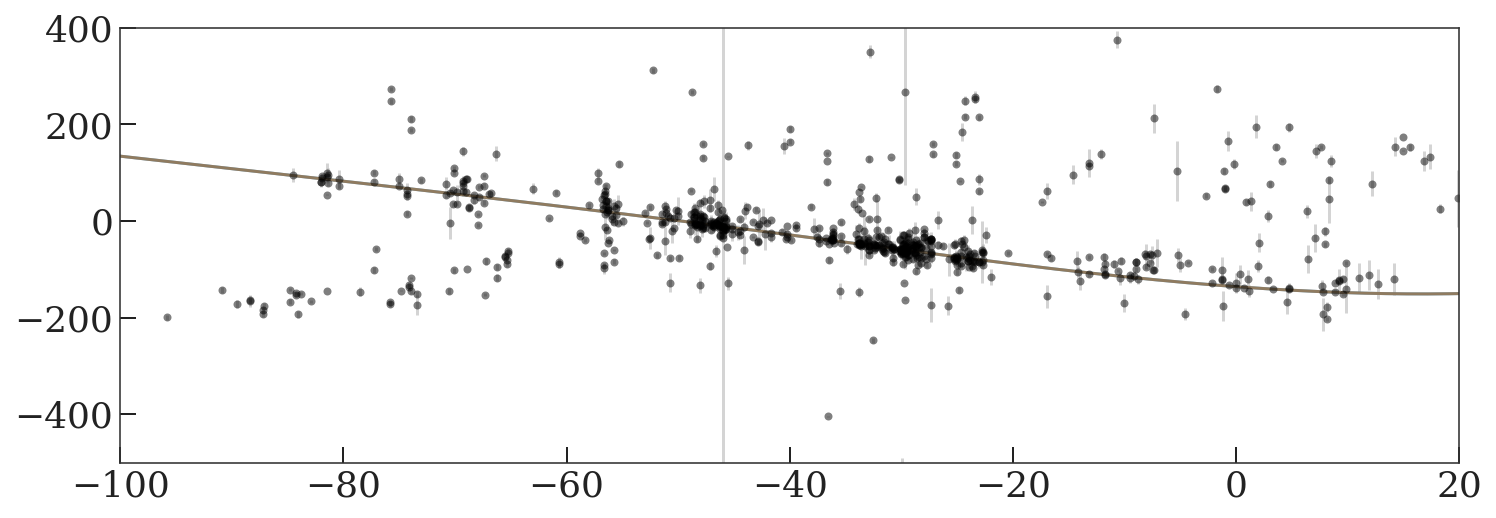

In [205]:
# off_data = RVJointModel.preprocess_data(opt_pars['offset']['rv0'], data)
off_data = data

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(
    off_data['phi1'],
    off_data['rv'],
    off_data['rv_error'],
    ls='none',
    marker='o',
    ecolor='#aaaaaa',
    alpha=0.5,
    ms=4
)

_grid = np.linspace(-100, 20, 256)
mean_spl = sci.InterpolatedUnivariateSpline(RVStreamModel.rv_knots, opt_pars['stream']['mean_rv'], k=3)
# ln_std_spl = sci.InterpolatedUnivariateSpline(RVStreamModel.rv_knots, opt_pars['stream']['ln_std_rv'], k=3)
# tmp_std = np.exp(ln_std_spl(_grid))
tmp_std = 0.
ax.plot(
    _grid, 
    mean_spl(_grid),
    marker=''
)
ax.plot(
    _grid, 
    mean_spl(_grid) + tmp_std,
    marker='',
    alpha=0.5
)

ax.set_xlim(-100, 20)
ax.set_ylim(-500, 400)